# Reinforcement Learning series: Tic-tac-toe game bot


In [1]:
### IMPORTS ###

ipynb = 'tic-tac-toe'

import sys, os, json
import tensorflow    as tf
import keras.backend as K

from ipywidgets           import widgets, HBox, VBox, Layout
from IPython.display      import display, HTML, Javascript as JS
from pandas               import DataFrame
from pathlib              import Path
from pprint               import pprint
from operator             import iconcat
from functools            import reduce, partial
from collections          import deque
from numpy                import *
from numpy.random         import *
from os.path              import isfile
from uuid                 import uuid4 as guid

from tensorflow                      import keras
from tensorflow.keras.layers         import Input, Dense, BatchNormalization, Activation, Multiply
from tensorflow.keras.losses         import mse, categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers     import Adam
from tensorflow.keras.regularizers   import l2
from tensorflow.keras.activations    import softmax
from tensorflow.keras.models         import Model, load_model, clone_model
from tensorflow.keras.callbacks      import LearningRateScheduler, LambdaCallback
from tensorflow.keras.utils          import Progbar, to_categorical

from matplotlib.pyplot    import *
from time                 import *

# %matplotlib inline

DIR = f'tmp/{ipynb}'
Path(DIR).mkdir(parents=True, exist_ok=True)
print('DIR =', DIR)

TESTS = 100

def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def time2str(t):
    return strftime("%b %d %Y %H:%M:%S", localtime(t))

def mtime(path):
    return os.path.getmtime(path)

def mtime2str(path):
    return time2str(mtime(path))

2023-03-26 13:08:30.633090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 13:08:30.729798: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 13:08:31.242534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-26 13:08:31.242598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

DIR = tmp/tic-tac-toe


## Problem formulation: Treating after-states as action-value function inputs

In [2]:
### ENVIRONMENT ###

# 0 1 2
# 3 4 5
# 6 7 8

winidx = [
    [ [0,1,2],          [0,3,6], [0,4,8] ], # 0 - (0,0)
    [ [0,1,2],          [1,4,7]          ], # 1 - (0,1)
    [ [0,1,2], [2,4,6], [2,5,8]          ], # 2 - (0,2)
    [ [3,4,5],          [0,3,6]          ], # 3 - (1,0)
    [ [3,4,5], [2,4,6], [1,4,7], [0,4,8] ], # 4 - (1,1)
    [ [3,4,5],          [2,5,8]          ], # 5 - (1,2)
    [ [6,7,8], [2,4,6], [0,3,6],         ], # 6 - (2,0)
    [ [6,7,8],          [1,4,7]          ], # 7 - (2,1)
    [ [6,7,8],          [2,5,8], [0,4,8] ], # 8 - (2,2)
]

encoding = array([
    [0,0], # 0
    [0,1], # 1
    [1,0], # 2
]) 

def onehot(s): 
    return concatenate(encoding[s.astype(int)])

def digits(s):
    return ''.join(int64(s).ravel().astype(str))

def other(p): 
    return (p%2)+1

def player(s):
    return other(count_nonzero(s))

def action2xy(a):
    x,y = unravel_index(a, (3,3))
    return (x,y)

def xy2action(x,y):
    a = ravel_multi_index((x,y), (3,3))
    return a

def enum_lines(a):
    return winidx[a]
            
def iswin(s,a):
    p = s[a]
    for line in enum_lines(a):
        if all(s[line] == p):
            return True
    return False

def canwin(s,a,p):
    a    = int(a)
    s[a] = p
    yes  = iswin(s,a)
    s[a] = 0
    return yes

def hasbegun(s):
    return count_nonzero(s) > 0

def isover(s):
    return count_nonzero(s) == len(s)

def game(s=None,a=None):
    winner = None
    if s is None:
        s = zeros(3*3)
    elif a is None:
        s = array(list(s)).astype(float)
    else:
        a    = int(a)
        assert(s[a] == 0)
        s    = copy(s)
        p    = player(s)
        s[a] = p
        if iswin(s,a):
            winner = p
        elif isover(s):
            winner = 0
    return s,winner    

def actions(s):
    aa = argwhere(s == 0)
    return concatenate(aa) if len(aa) > 0 else []

def actionmask(aa):
    aa       = aa.astype(int)
    mask     = zeros(9)
    mask[aa] = 1
    return mask

def selectaction(s,pi):
    aa,pp = pi(s)
    i     = choice(range(len(pp)), p=pp)
    return aa[i],pp[i]    

def getreward(agent, winner):
    rival = other(agent)
    if winner == agent:
        return 1
    if winner == rival:
        return -1
    return 0

def getoutcome(ss,aa,pp,rr,discount):
    outcome = {1:0,2:0}
    n       = len(rr)
    yy      = zeros_like(rr)
    for i in reversed(range(n)):
        actor          = player(ss[i])
        _,winner       = game(ss[i],aa[i])      
        if winner is not None:
            outcome    = {1:0,2:0}
        yy[i]          = rr[i] + outcome[actor]
        outcome[actor] = yy[i] * discount
    return yy

def episode(policy, start=None):
    n  = 0
    ss = zeros((9,9))
    aa = zeros((9))
    pp = zeros((9))
    s,winner = game() if start is None else (start,None)
    while winner is None:
        actor   = player(s)
        rival   = other(actor) 
        a,p     = selectaction(s, policy[actor])
        ss[n,:] = s
        aa[n]   = a
        pp[n]   = p
        n      += 1     
        s,winner = game(s, a)
    ss = ss[0:n,:]
    aa = aa[0:n]
    pp = pp[0:n]
    return winner,ss,aa,pp

def winratio(wins, agent=1):
    rival       = other(agent)
    draw_score  = wins[0] * 0.5
    agent_score = wins[agent] + draw_score
    rival_score = wins[rival] + draw_score
    ratio       = agent_score / (rival_score or 1)
    return ratio

def testgames(policy, iters=1000):
    ratio    = 0
    agent,*_ = policy.keys()
    rival    = other(agent)
    wins     = [0,0,0]
    progbar  = Progbar(target=iters, stateful_metrics=['draws','wins1','wins2','win ratio'])
    print(f'testing policy {agent}:{policy[agent].__name__} vs {rival}:{policy[rival].__name__}')
    for i in range(iters):
        winner,_,_,_  = episode(policy)
        wins[winner] += 1
        ratio         = winratio(wins,agent)
        progbar.update(i+1, values=[
            ('draws', wins[0]/10_000),
            ('wins1', wins[1]/10_000),
            ('wins2', wins[2]/10_000),
            ('win ratio', ratio),             
        ])    
    return ratio

def samplegames(policy, iters=100, start=None, progress=None):
    m       = 0
    sss     = zeros((9*iters,9))
    aaa     = zeros((9*iters))
    ppp     = zeros((9*iters))
    rrr     = zeros((9*iters))
    progbar = Progbar(target=iters, stateful_metrics=['total samples']) if progress else None
    for i in range(iters):
        winner,ss,aa,pp = episode(policy, start=start)
        rr              = zeros((len(ss)))
        rr[-1]          = getreward(player(ss[-1]), winner)
        rr[-2]          = getreward(player(ss[-2]), winner)
        d               = len(rr)
        sss[m:m+d,:]    = ss
        aaa[m:m+d]      = aa
        ppp[m:m+d]      = pp
        rrr[m:m+d]      = rr
        m              += d
        if progbar is not None:
            progbar.update(i+1, values=[
                ('samples per episode', d),
                ('total samples', m),
            ])    
    return sss[0:m,:], aaa[0:m], ppp[0:m], rrr[0:m]

class EnumProc:
    def __init__(self):
        self.__name__ = 'EnumProc'
        self.states   = [0,0,0]
        self.wins     = [0,0,0]
    def __call__(self, s, winner):
        p = player(s)
        self.states[p] += 1
        if winner is not None:
            self.wins[winner] += 1
            
def enum_states(proc):
    visited = {}
    def iter(s,w):
        key = digits(s)
        if key not in visited:
            visited[key] = 1
            proc(s,w)
            if w is None:
                for a in actions(s):
                    iter(*game(s,a))
    iter(*game())
    
def enum_policy(policy, proc):
    print(f'enumerating policy 1:{policy[1].__name__} vs 2:{policy[2].__name__} with {proc.__name__}')
    visited = {}
    def iter(s,w):
        key = digits(s)
        if key not in visited:
            visited[key] = 0
            proc(s,w)
            if w is None:
                actor = player(s)
                aa,pp = policy[actor](s)
                for a,p in zip(aa,pp):
                    if p > 0:
                        iter(*game(s,a))
        visited[key] += 1
    iter(*game())

def enum_policies(policies):
    policy1,policy2,states1,states2,draws,wins1,wins2 = [],[],[],[],[],[],[]
    for policy in policies:
        proc = EnumProc()
        enum_policy(policy, proc)
        policy1.append(policy[1].__name__)
        policy2.append(policy[2].__name__)
        states1.append(proc.states[1])
        states2.append(proc.states[2])
        draws.append(proc.wins[0])
        wins1.append(proc.wins[1])
        wins2.append(proc.wins[2])
    return DataFrame(data={
        'policy1': policy1,
        'policy2': policy2,
        'states1': states1,
        'states2': states2,
        'draws': draws,
        'wins1': wins1,
        'wins2': wins2
    })    
    
def argsmax(values):
    return unique(ravel(argwhere(values == max(values))))
        
def lookahead(s, aa):
    actor = player(s)
    ww    = [game(s,a)[1] for a in aa]
    ii    = [i for i,w in enumerate(ww) if w == actor]
#     if len(ii) == 0:
#         rival = other(actor)
#         ii    = [i for i,a in enumerate(aa) if canwin(s,a,rival)]
    return ii
    
def uniformprob(aa,ii):
    pp     = zeros_like(aa).astype(float)
    pp[ii] = array(1/len(ii))
    return pp

def argmaxprob(qq):
    ii = argsmax(qq)
    pp = uniformprob(qq,ii)
    return ravel(pp)

def softmaxprob(zz):
    max_z = max(zz)
    num   = exp(zz - max_z) 
    den   = sum(num)
    return num / den

def randompi(s):
    aa = actions(s)
    n  = len(aa)
    pp = array([1/n] * n)
    return aa,pp

def lookaheadpi(pi):
    @rename(f'lookaheadpi({pi.__name__})')
    def lookaheadpi(s):
        aa = actions(s)
        ii = lookahead(s, aa)
        if len(ii) > 0: 
            pp = uniformprob(aa,ii)
            return aa,pp
        return pi(s)    
    return lookaheadpi

def maxpi(pi):
    @rename(f'maxpi({pi.__name__})')
    def maxpi(s):
        aa,pp = pi(s)
        pp    = argmaxprob(pp)
        return aa,pp
    return maxpi

def percentilepi(pi, centile=90):
    @rename(f'percentilepi({pi.__name__})')
    def percentilepi(s):
        aa,pp = pi(s)
        th    = percentile(pp,centile)
        ii    = argwhere(pp >= th)
        pp    = uniformprob(aa,ii)
        return aa,pp
    return percentilepi

def explorepi(pi, epsilon=0.1):
    @rename(f'explorepi({pi.__name__},{epsilon})')
    def explorepi(s):
        if random() < epsilon:
            return randompi(s)
        return pi(s)
    return explorepi

def choicepi(*policies):
    names = ','.join([pi.__name__ for pi in policies])
    @rename(f'choicepi({names})')
    def choicepi(s):
        pi = choice(policies)
        return pi(s)
    return choicepi

def switchpi(*policies):
    pi    = choice(policies)
    names = ','.join([pi.__name__ for pi in policies])
    @rename(f'switchpi({names})')
    def switchpi(s):
        nonlocal pi
        if count_nonzero(s) < 2:
            pi = choice(policies)
        return pi(s)
    return switchpi

def qpi(model):
    @rename(f'qpi({model.__name__})')
    def qpi(s):
        aa = actions(s)
        qq = array([model([s,a]) for a in aa])
        pp = argmaxprob(qq)
        return aa,pp
    return qpi

def iter_under_policy(policy, iters=100, games=1, rates={0:0.1}, epsilons={0:0.1}, proc=print):
    print(f'iterating under policy {1}:{policy[1].__name__} vs {2}:{policy[2].__name__}')
    progbar  = Progbar(target=iters, stateful_metrics=['rate', 'epsilon'])
    errors   = zeros(iters) 
    rewards  = [None, zeros(iters), zeros(iters)]
    for i in range(iters):
        if i in rates:
            rate = rates[i]
        if i in epsilons:
            epsilon = epsilons[i]
            policy2 = {
                1:explorepi(policy[1], epsilon),
                2:explorepi(policy[2], epsilon),
            }
        ss,aa,pp,rr = samplegames(policy=policy2, iters=games)
        errors[i]   = proc(ss,aa,pp,rr,rate=rate) or 0
        for s,r in zip(ss,rr):
            actor = player(s)
            rewards[actor][i] += r/games 
        values = [
            ('rate',      rate),
            ('epsilon',   epsilon), 
            ('error',     errors[i]),
            ('reward[X]', rewards[1][i]),
            ('reward[O]', rewards[2][i])
        ]
        progbar.update(i+1, values)
    figure()
    plot(errors,'r')
    plot(rewards[1])
    plot(rewards[2])
    title('objective history')
    ylabel('objective')
    xlabel(f'games x{games}')
    legend(['error', 'reward[X]', 'reward[O]'], loc='upper left')
    savefig(f'{DIR}/{policy[1].__name__}-vs-{policy[2].__name__}.png')
    show()   

seed(42)

ss,aa,pp,rr = samplegames({ 1:randompi, 2:randompi }, iters=10, progress=True)
print(f'{ss = }\n')
print(f'{aa = }\n')
print(f'{pp = }\n')
print(f'{rr = }\n')

testgames({ 1:randompi, 2:randompi },iters=TESTS)

enum_policies([
    {1:randompi,              2:randompi},
    {1:lookaheadpi(randompi), 2:randompi},
    {1:randompi,              2:lookaheadpi(randompi)},
    {1:lookaheadpi(randompi), 2:lookaheadpi(randompi)},
])


10/10 [==============================] - 0s 534us/step - samples per episode: 6.9000 - total samples: 69.0000
ss = array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 2.],
       [0., 0., 0., 1., 0., 0., 1., 0., 2.],
       [0., 0., 0., 1., 2., 0., 1., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 0., 0., 0., 0., 0., 0., 1.],
       [2., 1., 0., 0., 0., 2., 0., 0., 1.],
       [2., 1., 0., 0., 0., 2., 1., 0., 1.],
       [2., 1., 2., 0., 0., 2., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 2., 0., 0., 0., 0., 0., 1., 0.],
       [0., 2., 1., 0., 0., 0., 0., 1., 0.],
       [0., 2., 1., 2., 0., 0., 0., 1., 0.],
       [0., 2., 1., 2., 1., 0., 0., 1., 0.],
       [0., 2., 1., 2., 1., 0., 2., 1., 0.],
       [0., 2., 1., 2., 1., 1.

,policy1,policy2,states1,states2,draws,wins1,wins2
0,randompi,randompi,2739,2739,16,626,316
1,lookaheadpi(randompi),randompi,2701,2581,16,604,316
2,randompi,lookaheadpi(randompi),2701,2733,16,620,316
3,lookaheadpi(randompi),lookaheadpi(randompi),2657,2569,16,604,316


## Jupyter Widgets: Simple game frontend to try agents right here in the notebook

In [3]:
### FRONTEND ###

def play(policy):
    state   = None
    board   = None
    agent   = None
    rival   = None
    
    def moveagent(s, a):
        aa,pp    = policy[agent](s)
        i        = choice(range(len(pp)), p=pp)
        a,p      = aa[i],pp[i]
        s,winner = game(s, a)
        return s,winner

    def display_board(onclick):
        board = []
        for i in range(9):
            btn = widgets.Button(
                description  = '',
                disabled     = False,
                button_style = '', # 'success', 'info', 'warning', 'danger' or ''
                tooltip      = 'Click me',
                icon         = '',
                layout       = Layout(width='40px', height='40px')
            )
            btn.action = i
            btn.on_click(lambda btn: onclick(btn.action))
            board.append(btn)
        display(VBox([
            HBox([board[0],board[1],board[2]]),
            HBox([board[3],board[4],board[5]]),
            HBox([board[6],board[7],board[8]])
        ]))
        return board
        
    def update_board(board, state):
        chars = [' ', 'x', 'o']
        state = state.astype(int)
        for i in range(9):
            board[i].description = chars[state[i]]

    def gameturn(s=None, a=None):
        s,winner = game(s,a)
#         print(reshape(s, (3,3)))
        update_board(board, s)
        if winner is None and player(s) == agent:
            s,winner = moveagent(s,a)
            update_board(board, s)
        if winner is not None:
            msgs = ['DRAW','X WINS','O WINS']
            print(msgs[winner])
            for i in range(9):
                board[i].disabled = True
            play(policy)
        return s,winner

    def onclick(a): 
        nonlocal state
        if (player(state) != agent) and (a in actions(state)):
            state,winner = gameturn(state,a)

    assert(1 in policy or 2 in policy)    
    if 1 in policy:
        agent,rival = 1,2
    elif 2 in policy:
        agent,rival = 2,1
    print(f'play against {policy[agent].__name__}')
    
    board        = display_board(onclick=onclick)
    state,winner = gameturn()

play(policy={1:lookaheadpi(randompi)})
 

play against lookaheadpi(randompi)


## Tabular Reinforcement Learning

### Dynamic Programming: Action-value iteration
Action-value iteration works by iteratively applying the Bellman optimality equation for $q_{\ast}$ to a working action-value function, as an update rule, as shown below.

$$\large q_{\ast}(s, a) = \sum_{s', r} p(s', r | s, a)[r + \gamma v_{\ast}(s')]$$

Alternatively we can express this equation in terms of $q_{\ast}$ itself.

$$\large q_{\ast}(s, a) = \sum_{s', r} p(s', r | s, a)[r + \gamma \max_{a'} q_{\ast}(s', a')]$$


In [4]:
### TABULAR-DYNAMIC-PROGRAMMING ###

class qtable(dict):
    def __init__(self, name):
        self.__name__ = name
    def __call__(self, input):
        s,a = input
        s,_ = game(s,a)
        key = digits(s)
        q   = self.get(key,0)
        return q
    def path(self):
        return f'{DIR}/{self.__name__}.npy'
    def save(self):
        save(self.path(), self)
    def load(self):
        tmp = load(self.path(), allow_pickle=True)
        self.update(tmp.item())
    def exists(self):
        return isfile(self.path())
    
def iter_qvalue(table, iters=10, target=1e-8):    
    def eval_afterstate(after_state, winner):    
        new_value = 0
        rival     = player(after_state)
        agent     = other(rival)
        if winner is None: 
            rival_actions = actions(after_state)
            rival_prob    = 1 / len(rival_actions)
            for rival_action in rival_actions:
                next_state,winner = game(after_state, rival_action)
                if winner is None: 
                    max_next_value = max([table(next_state,a) for a in actions(next_state)])
                    new_value     += rival_prob * (0 + max_next_value)
                else:
                    assert(winner != agent)
                    reward     = -1 if winner == rival else 0
                    new_value += rival_prob * (reward + 0)
                    if winner == rival:              # commenting this  
                        new_value = 1 * (reward + 0) # prevents player2
                        break                        # from learning optimal policy
        else:
            assert(winner != rival)
            reward    = 1 if winner == agent else 0
            new_value = 1 * (reward + 0)
        key        = digits(after_state)
        old_value  = table.get(key, 0)
        table[key] = new_value
        return abs(old_value - new_value)
    delta = 0
    def proc(state, winner):
        nonlocal delta
        delta = max(delta, eval_afterstate(state, winner))
    progbar = Progbar(target=iters, stateful_metrics=['delta'])
    for i in range(iters):
        delta = 0
        enum_states(proc)
        progbar.update(i+1, values=[('delta',  delta)]) 
        if delta <= target:
            break
    print('\n')
         
dptable = qtable('dptable')  
if dptable.exists():
    dptable.load()
else:
    iter_qvalue(dptable, iters=100, target=1e-08)
    dptable.save()
print('dptable:', len(dptable))
mtime2str(dptable.path())

agentpi = qpi(dptable) 
rivalpi = lookaheadpi(randompi)

testgames({1:agentpi, 2:rivalpi}, iters=TESTS)
testgames({2:agentpi, 1:rivalpi}, iters=TESTS)
testgames({1:agentpi, 2:agentpi}, iters=TESTS)

enum_policies([
    {1:agentpi, 2:rivalpi},
    {1:rivalpi, 2:agentpi},
    {1:agentpi, 2:agentpi},
])


dptable: 5478
testing policy 1:qpi(dptable) vs 2:lookaheadpi(randompi)
100/100 [==============================] - 0s 1ms/step - draws: 0.0000e+00 - wins1: 0.0100 - wins2: 0.0000e+00 - win ratio: 100.0000
testing policy 2:qpi(dptable) vs 1:lookaheadpi(randompi)
100/100 [==============================] - 0s 1ms/step - draws: 9.0000e-04 - wins1: 0.0000e+00 - wins2: 0.0091 - win ratio: 21.2222
testing policy 1:qpi(dptable) vs 2:qpi(dptable)
100/100 [==============================] - 0s 2ms/step - draws: 0.0100 - wins1: 0.0000e+00 - wins2: 0.0000e+00 - win ratio: 1.0000
enumerating policy 1:qpi(dptable) vs 2:lookaheadpi(randompi) with EnumProc
enumerating policy 1:lookaheadpi(randompi) vs 2:qpi(dptable) with EnumProc
enumerating policy 1:qpi(dptable) vs 2:qpi(dptable) with EnumProc


,policy1,policy2,states1,states2,draws,wins1,wins2
0,qpi(dptable),lookaheadpi(randompi),1219,1004,7,554,0
1,lookaheadpi(randompi),qpi(dptable),577,737,16,0,260
2,qpi(dptable),qpi(dptable),25,26,7,0,0


In [ ]:
play(policy={2:agentpi})

### Monte-Carlo RL:

$$\large V(S_t) = V(S_t) + \alpha [ G_t - V(S_t) ]$$

$$\large Q(S_t,A_t) = Q(S_t,A_t) + \alpha [ G_t - Q(S_t,A_t) ]$$


In [5]:
### TABULAR-MONTE-CARLO ###

def mctrain(table, discount=0.99, iters=100, games=1, rates={0:0.1}, epsilons={0:0.1}):
    def mcproc(ss,aa,pp,rr,rate=0.1):
        error = 0
        yy    = getoutcome(ss,aa,pp,rr,discount=discount)
        for s,a,y in zip(ss,aa,yy):
            key         = digits(game(s,a)[0])
            q           = table.get(key, 0)
            diff        = y - q
            table[key]  = q + rate*diff
            error      += abs(diff)
        return error / len(ss)
    agentpi = lookaheadpi(qpi(table))
    policy  = {1:agentpi,2:agentpi}
    iter_under_policy(policy, iters=iters, games=games, rates=rates, epsilons=epsilons, proc=mcproc)
        
seed(42)
mctable = qtable('mctable')   
if mctable.exists():
    mctable.load()
else:
    mctrain(mctable, 
            discount = 0.99, 
            iters    = 10_000, 
            games    = 10, 
            rates    = { 0:0.1 }, 
            epsilons = { 0:0.1, 5000:0.05 })
    mctable.save()
print('mctable:', len(mctable))
mtime2str(mctable.path())
          
agentpi = qpi(mctable) 
rivalpi = lookaheadpi(randompi)

testgames({1:agentpi, 2:rivalpi}, iters=TESTS)
testgames({2:agentpi, 1:rivalpi}, iters=TESTS)
testgames({1:agentpi, 2:agentpi}, iters=TESTS)

enum_policies([
    {1:agentpi, 2:rivalpi},
    {1:rivalpi, 2:agentpi},
    {1:agentpi, 2:agentpi},
])


mctable: 4732
testing policy 1:qpi(mctable) vs 2:lookaheadpi(randompi)
100/100 [==============================] - 0s 1ms/step - draws: 0.0000e+00 - wins1: 0.0100 - wins2: 0.0000e+00 - win ratio: 100.0000
testing policy 2:qpi(mctable) vs 1:lookaheadpi(randompi)
100/100 [==============================] - 0s 1ms/step - draws: 0.0012 - wins1: 0.0000e+00 - wins2: 0.0088 - win ratio: 15.6667 
testing policy 1:qpi(mctable) vs 2:qpi(mctable)
100/100 [==============================] - 0s 2ms/step - draws: 0.0100 - wins1: 0.0000e+00 - wins2: 0.0000e+00 - win ratio: 1.0000
enumerating policy 1:qpi(mctable) vs 2:lookaheadpi(randompi) with EnumProc
enumerating policy 1:lookaheadpi(randompi) vs 2:qpi(mctable) with EnumProc
enumerating policy 1:qpi(mctable) vs 2:qpi(mctable) with EnumProc


,policy1,policy2,states1,states2,draws,wins1,wins2
0,qpi(mctable),lookaheadpi(randompi),94,87,3,63,0
1,lookaheadpi(randompi),qpi(mctable),264,318,12,0,148
2,qpi(mctable),qpi(mctable),5,5,1,0,0


In [ ]:
play(policy={2:agentpi})

### Temporal difference: Q-Learning

$$\large V(S_t) = V(S_t) + \alpha [ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) ]$$

$$\large Q(S_t, A_t) = Q(S_t, A_t) + \alpha [ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) ]$$

$$\large Q(S_t, A_t) = Q(S_t, A_t) + \alpha [ R_{t+1} + \gamma \max_{a} Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) ]$$

...

In [6]:
### TABULAR-TEMPORAL-DIFFERENCE ###
        
def tdtrain(table, discount=0.99, iters=100, games=1, rates={0:0.1}, epsilons={0:0.1}):
    def tdproc(ss,aa,pp,rr,rate=0.1):
        error = 0
        n     = len(ss)
        for j in reversed(range(n)):
            reward    = rr[j]
            after_s,_ = game(ss[j],aa[j])
            key       = digits(after_s)
            q         = table.get(key, 0)
            if j+1 < n and all(after_s == ss[j+1]):
                next_s,_   = game(ss[j+1],aa[j+1])
                qq         = [table(next_s,a) for a in actions(next_s)]
                max_next_q = max(qq) if len(qq) > 0 else 0
            else:    
                max_next_q = 0
            diff       = reward + discount*max_next_q - q
            table[key] = q + rate*diff                
            error     += abs(diff)
        return error / n
    agentpi = lookaheadpi(qpi(table))
    policy  = {1:agentpi,2:agentpi}
    iter_under_policy(policy, iters=iters, games=games, rates=rates, epsilons=epsilons, proc=tdproc)
        
seed(42)
tdtable = qtable('tdtable')   
if tdtable.exists():
    tdtable.load()
else:
    tdtrain(tdtable, 
        discount = 0.99, 
        iters    = 10_000, 
        games    = 30, 
        rates    = {0:0.1, 3_000:0.01, 7_000:0.001}, 
        epsilons = {0:0.1, 5_000: 0.05})
    tdtable.save()
print('tdtable:', len(tdtable))
mtime2str(tdtable.path())
      
agentpi = qpi(tdtable) 
rivalpi = lookaheadpi(randompi)

testgames({1:agentpi, 2:rivalpi}, iters=TESTS)
testgames({2:agentpi, 1:rivalpi}, iters=TESTS)
testgames({1:agentpi, 2:agentpi}, iters=TESTS)

enum_policies([
    {1:agentpi, 2:rivalpi},
    {1:rivalpi, 2:agentpi},
    {1:agentpi, 2:agentpi},
])
    

tdtable: 4461
testing policy 1:qpi(tdtable) vs 2:lookaheadpi(randompi)
100/100 [==============================] - 0s 1ms/step - draws: 0.0000e+00 - wins1: 0.0100 - wins2: 0.0000e+00 - win ratio: 100.0000
testing policy 2:qpi(tdtable) vs 1:lookaheadpi(randompi)
100/100 [==============================] - 0s 1ms/step - draws: 1.0000e-03 - wins1: 0.0000e+00 - wins2: 0.0090 - win ratio: 19.0000
testing policy 1:qpi(tdtable) vs 2:qpi(tdtable)
100/100 [==============================] - 0s 2ms/step - draws: 0.0100 - wins1: 0.0000e+00 - wins2: 0.0000e+00 - win ratio: 1.0000
enumerating policy 1:qpi(tdtable) vs 2:lookaheadpi(randompi) with EnumProc
enumerating policy 1:lookaheadpi(randompi) vs 2:qpi(tdtable) with EnumProc
enumerating policy 1:qpi(tdtable) vs 2:qpi(tdtable) with EnumProc


,policy1,policy2,states1,states2,draws,wins1,wins2
0,qpi(tdtable),lookaheadpi(randompi),90,87,4,62,0
1,lookaheadpi(randompi),qpi(tdtable),260,312,12,0,146
2,qpi(tdtable),qpi(tdtable),5,5,1,0,0


In [ ]:
play(policy={2:agentpi})

### Monte Carlo Tree Search

$$\large UCT(S,a) = \frac{Q(S_a)}{N(S_a)} + \alpha*\sqrt{\frac{2\ln{N(S)}}{N(S_a)}}$$

$$\large PUCT(S,a) = \frac{Q(S_a)}{N(S_a)} + \alpha*P(S,a)\sqrt{\frac{\sum_b{N(S_b)}}{(1+N(S_a))}}$$


In [7]:
### MONTE-CARLO-TREE-SEARCH ###

class mctstable(qtable):
    def __init__(self, name):
        self.__name__ = name
        self.notfound = None
    def __call__(self, input):
        s,a = input
        s,_ = game(s,a)
        key = digits(s)
        if key in self:
            uid = self[key]
            return self[uid]['value']
        if self.notfound is not None:
            self.notfound.add(key)
        return 0   
    
def rot0(M):     return M
def rot180(M):   return rot90(M,2)
def rot270(M):   return rot90(M,3)
def fliptrbl(M): return transpose(M)
def fliptlbr(M): return transpose(rot90(M,2))

rotations = [ rot0,   rot90,  rot180,   rot270   ]
flips     = [ fliplr, flipud, fliptlbr, fliptrbl ]

def map_rotations_and_flips():
    statemap  = {}
    actionmap = {}
    state   = array(arange(9))
    for f in rotations+flips:
        s1 = ravel(f(reshape(state,(3,3))))
        s2 = zeros_like(s1)
        for i,x in enumerate(s1):
            s2[x] = i;
        statemap [f.__name__] = s1
        actionmap[f.__name__] = s2
    return statemap,actionmap
    
statemap,actionmap = map_rotations_and_flips()
for f in rotations+flips:
    print(f.__name__, statemap[f.__name__], actionmap[f.__name__])
print()
    
def rotate_and_flip(x):
    if isscalar(x): 
        x = int(x)
        return array([ idx[x] for idx in actionmap.values() ])
    else: 
        return array([ x[idx] for idx in statemap.values()  ])
    
def getstats(table, state):
    key = digits(state)    
    if key not in table:
        uid        = str(guid())
        table[uid] = { 'value': 0, 'visits': 0 }
        for s in rotate_and_flip(state):
            k = digits(s)
            if k not in table:
                table[k] = uid
    uid = table[key]
    return table[uid]

def makenode(table, state, parent=None, terminal=False):
    return {'parent'   : parent,
            'stats'    : getstats(table, state),
            'branches' : { a:None for a in actions(state) } if not terminal else None
           }

def isterminal(node):
    return node['branches'] is None

def isexpanded(node):
    if isterminal(node):
        return False
    for child in node['branches'].values():
        if child is None:
            return False
    return True

def backpropagate(node, reward):
    while node is not None:
        stats            = node['stats']
        stats['visits'] += 1
        stats['value']  += (reward - stats['value']) / stats['visits']
        node             = node['parent']
        reward           = -reward

def expandbranch(table, node, state):
    assert(not isterminal(node))
    assert(not isexpanded(node))
    branches          = node['branches']
    actor             = player(state)
    actions           = list(branches.keys())
    unknown           = [ a for a in actions if branches[a] is None ]
    action            = choice(unknown)
    next_state,winner = game(state,action)
    child             = makenode(table, next_state, parent=node, terminal=winner is not None)
    branches[action]  = child
    if isterminal(child):
        reward = getreward(actor, winner) 
        backpropagate(child, reward)
    return child,next_state
                
def ucb1(node, action, exploration): 
    n     = node['stats']['visits']
    child = node['branches'][action]
    nj    = child['stats']['visits']
    xj    = child['stats']['value']
    if exploration == 0:
        return xj
    if n == 0 or nj == 0:
        return float('inf')
    return xj + exploration*sqrt(2*log(n)/nj)

def selectbranchpi(node, exploration=0):
    assert(isexpanded(node))
    actions  = list(node['branches'].keys())
    values   = array([ ucb1(node,a,exploration) for a in actions ])
    probs    = argmaxprob(values)
    return actions,probs

def selectbranch(node, state, exploration):
    actions,probs = selectbranchpi(node, exploration)
    action        = choice(actions, p=probs)
    node          = node['branches'][action]
    state,_       = game(state, action)
    return node,state

def selectnode(table, node, state, exploration):
    while isexpanded(node):
        node,state = selectbranch(node, state, exploration)
    if not isterminal(node):
        node,state = expandbranch(table, node, state)
    return node,state

def simulatefrom(leaf, state, policy):
    if isterminal(leaf):
        return leaf['stats']['value']
    actor        = player(state)
    winner,_,_,_ = episode(policy, start=state)
    reward       = getreward(actor, winner)
    return reward 
    
def search(table, node, state, policy, exploration=1):
    leaf,state = selectnode(table, node, state, exploration)
    reward     = simulatefrom(leaf, state, policy)
    backpropagate(leaf, reward)
    return reward

def searchpi(table, timeout=1, policy={1:randompi,2:randompi}):
    @rename(f'searchpi({len(table)},{timeout})')
    def searchpi(s):
        t    = time()
        node = makenode(table, s)
        search(table, node, s, policy)
        while time() - t < timeout:
            search(table, node, s, policy)
        aa,pp = selectbranchpi(node, exploration=0)
        return aa,pp
    return searchpi

def train(table, policy, iters, exploration=1):
    state    = game()[0]
    root     = makenode(table, state)
    progbar  = Progbar(target=iters, stateful_metrics=[])
#     progress = PROGRESS(path=f'{DIR}/progress.log')
    for i in range(progbar.target):
        reward = search(table, root, state, policy, exploration)
        size   = len(table) 
        progbar.update(i+1, values=[('reward',reward),('size',size)])
#         progress(f'{ipynb}, iter {i+1} of {iters}, reward {reward}, size {size}')   

seed(41)   
          
playoutpi = switchpi(randompi, lookaheadpi(randompi)) 
          
mctsdata = mctstable('mctsdata')      
policy   = {1:playoutpi,2:playoutpi}
if mctsdata.exists():
    mctsdata.load()
else:
    train(mctsdata, policy, iters=500_000, exploration=10)
    mctsdata.save()
mtime2str(mctsdata.path())
          
agentpi = searchpi(mctsdata,0.1)
rivalpi = lookaheadpi(randompi)        
ratio1  = testgames({1:agentpi, 2:rivalpi}, iters=10)          
ratio2  = testgames({2:agentpi, 1:rivalpi}, iters=10)          

mctsdata.notfound = set() 
agentpi = qpi(mctsdata)
enum_policies([
    {1:agentpi, 2:randompi},
    {1:agentpi, 2:lookaheadpi(randompi)},
    {1:agentpi, 2:qpi(dptable)},
    {1:agentpi, 2:qpi(mctable)},
    {1:agentpi, 2:qpi(tdtable)},
    {2:agentpi, 1:randompi},
    {2:agentpi, 1:lookaheadpi(randompi)},
    {2:agentpi, 1:qpi(dptable)},
    {2:agentpi, 1:qpi(mctable)},
    {2:agentpi, 1:qpi(tdtable)},
])


rot0 [0 1 2 3 4 5 6 7 8] [0 1 2 3 4 5 6 7 8]
rot90 [2 5 8 1 4 7 0 3 6] [6 3 0 7 4 1 8 5 2]
rot180 [8 7 6 5 4 3 2 1 0] [8 7 6 5 4 3 2 1 0]
rot270 [6 3 0 7 4 1 8 5 2] [2 5 8 1 4 7 0 3 6]
fliplr [2 1 0 5 4 3 8 7 6] [2 1 0 5 4 3 8 7 6]
flipud [6 7 8 3 4 5 0 1 2] [6 7 8 3 4 5 0 1 2]
fliptlbr [8 5 2 7 4 1 6 3 0] [8 5 2 7 4 1 6 3 0]
fliptrbl [0 3 6 1 4 7 2 5 8] [0 3 6 1 4 7 2 5 8]

testing policy 1:searchpi(6239,0.1) vs 2:lookaheadpi(randompi)
10/10 [==============================] - 3s 347ms/step - draws: 1.0000e-04 - wins1: 9.0000e-04 - wins2: 0.0000e+00 - win ratio: 19.0000
testing policy 2:searchpi(6239,0.1) vs 1:lookaheadpi(randompi)
10/10 [==============================] - 4s 359ms/step - draws: 2.0000e-04 - wins1: 0.0000e+00 - wins2: 8.0000e-04 - win ratio: 9.0000
enumerating policy 1:qpi(mctsdata) vs 2:randompi with EnumProc
enumerating policy 1:qpi(mctsdata) vs 2:lookaheadpi(randompi) with EnumProc
enumerating policy 1:qpi(mctsdata) vs 2:qpi(dptable) with EnumProc
enumerating policy 

,policy1,policy2,states1,states2,draws,wins1,wins2
0,qpi(mctsdata),randompi,177,181,8,132,0
1,qpi(mctsdata),lookaheadpi(randompi),177,181,8,132,0
2,qpi(mctsdata),qpi(dptable),29,33,8,0,0
3,qpi(mctsdata),qpi(mctable),8,9,2,0,0
4,qpi(mctsdata),qpi(tdtable),8,9,2,0,0
5,randompi,qpi(mctsdata),449,589,16,0,228
6,lookaheadpi(randompi),qpi(mctsdata),449,589,16,0,228
7,qpi(dptable),qpi(mctsdata),25,26,7,0,0
8,qpi(mctable),qpi(mctsdata),17,16,3,0,0
9,qpi(tdtable),qpi(mctsdata),17,17,4,0,0


In [ ]:
print(len(mctsdata.notfound))
pprint(mctsdata)

In [ ]:
play(policy={2:searchpi(mctsdata,1)})

## Approximate Reinforcement Learning:  Neural networks

### Policy Gradients: REINFORCE

$$\large \nabla J(\theta) \propto \sum_s \mu(s) \sum_a q_\pi(s,a) \nabla \pi(a|s, \theta)$$


2023-03-26 13:09:16.199788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 13:09:16.206295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 13:09:16.206664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 13:09:16.207473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "pimodel1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           608         ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 9)            297         ['dense[0][0]']                  
                                                                                                  
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                           

2023-03-26 13:09:17.631180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-26 13:09:20.829737: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d829990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-26 13:09:20.829770: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-26 13:09:20.836174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-26 13:09:20.954424: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 875s 3s/step - rate: 1.0000e-03 - epsilon: 0.1000 - error: 0.1976 - reward[X]: 0.5002 - reward[O]: -0.5002


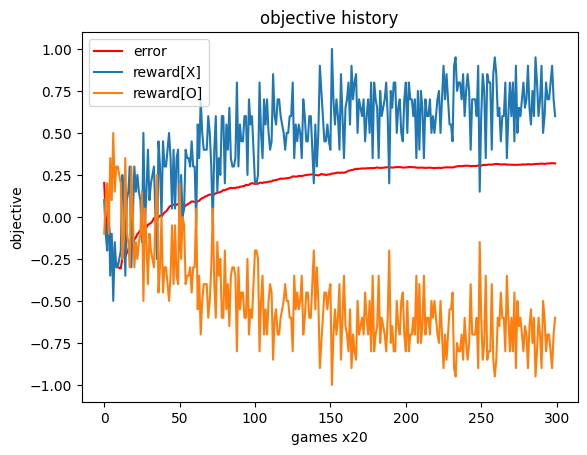

testing policy 1:pimodel1 vs 2:lookaheadpi(randompi)
  1/100 [..............................] - ETA: 13s - draws: 0.0000e+00 - wins1: 1.0000e-04 - wins2: 0.0000e+00 - win ratio: 1.0000

/home/undwad/ipynb/jupyterenv/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


100/100 [==============================] - 16s 159ms/step - draws: 7.0000e-04 - wins1: 0.0082 - wins2: 0.0011 - win ratio: 5.8966
testing policy 1:maxpi(pimodel1) vs 2:lookaheadpi(randompi)
100/100 [==============================] - 14s 143ms/step - draws: 2.0000e-04 - wins1: 0.0097 - wins2: 1.0000e-04 - win ratio: 49.0000
enumerating policy 1:maxpi(pimodel1) vs 2:lookaheadpi(randompi) with EnumProc
enumerating policy 1:maxpi(pimodel1) vs 2:qpi(dptable) with EnumProc
enumerating policy 1:maxpi(pimodel1) vs 2:qpi(mctable) with EnumProc
enumerating policy 1:maxpi(pimodel1) vs 2:qpi(tdtable) with EnumProc
enumerating policy 1:maxpi(pimodel1) vs 2:qpi(mctsdata) with EnumProc


,policy1,policy2,states1,states2,draws,wins1,wins2
0,maxpi(pimodel1),lookaheadpi(randompi),59,51,2,31,2
1,maxpi(pimodel1),qpi(dptable),7,4,0,0,3
2,maxpi(pimodel1),qpi(mctable),4,3,0,0,1
3,maxpi(pimodel1),qpi(tdtable),4,3,0,0,1
4,maxpi(pimodel1),qpi(mctsdata),4,3,0,0,1


In [8]:
### POLICY-GRADIENTS ###

class pimodel(Model):
    def __init__(self, name, *nn):
        inf   = tf.constant(np.finfo(np.float32).min)
        mask  = Input((nn[-1],)) 
        m     = tf.cast(mask, dtype=tf.dtypes.bool)
        x     = Input((nn[0],))
        y     = x
        for n in nn[1:-1]:
            y = Dense(n, activation='relu', trainable=True)(y)
        y     = Dense(nn[-1], trainable=True)(y)
        ones  = tf.ones_like(y)
        my    = tf.where(m, y, ones*inf)
        z     = softmax(my)
        super().__init__(inputs=[x,mask], outputs=z, name=name)
        optimizer     = Adam(lr=0.001, clipnorm=1.0)
        self.compile(loss=categorical_crossentropy, optimizer=optimizer)     
        self.__name__ = name      
    def __call__(self, input, training=None):
        if training is not None: 
            return  super().__call__(input, training=training)
        s    = input
        aa   = actions(s)        
        xx   = array([onehot(s)]) 
        mask = array([actionmask(aa)])
        zz   = self.predict([xx,mask], verbose=0)
        pp   = ravel(zz)[aa]
        return aa,pp
    def __str__(self):
        return self.name
    def path(self):
        return f'{DIR}/{self.__name__}.npy'
    def save(self):
        save(self.path(), self.get_weights())
    def load(self):
        weights = load(self.path())
        self.set_weights(weights)
    def exists(self):
        return isfile(self.path())

def train(models, discount=0.99, iters=100, games=1, rates={0:0.1}, epsilons={0:0.1}):
    avg_y         = 0
    agent,*_      = models.keys()
    rival         = other(agent)
    model         = models[agent]
    policy        = {}    
    policy[agent] = model
    policy[rival] = models[rival] if rival in models else lookaheadpi(randompi)
    def proc(ss,aa,pp,rr,rate=0.1):
        K.set_value(model.optimizer.lr, rate)
        yy       = getoutcome(ss,aa,pp,rr,discount=discount)
        ii       = [i for i,s in enumerate(ss) if agent == player(s)] 
        ss,aa,yy = ss[ii],aa[ii],yy[ii]
        xx       = array([onehot(s) for s in ss])
        mask     = array([actionmask(actions(s)) for s in ss])
        ohaa     = to_categorical(aa,9)
        error    = model.train_on_batch(x=[xx,mask], y=ohaa, sample_weight=yy, reset_metrics=False)
        return error
    iter_under_policy(policy, iters=iters, games=games, rates=rates, epsilons=epsilons, proc=proc)
                
seed(42)
pimodel1 = pimodel('pimodel1',18,32,9)  
print(pimodel1.summary())

if pimodel1.exists():
    pimodel1.load()
else:
    train({1:pimodel1}, 
        discount = 0.99, 
        iters    = 300, 
        games    = 20, 
        rates    = {0:0.01, 200:0.001}, 
        epsilons = {0:0.1, 1000: 0.1})
    pimodel1.save()
mtime2str(pimodel1.path())

agentpi = pimodel1
rivalpi = lookaheadpi(randompi)
testgames({1:agentpi, 2:rivalpi}, iters=TESTS)

agentpi = maxpi(pimodel1)
rivalpi = lookaheadpi(randompi)
testgames({1:agentpi, 2:rivalpi}, iters=TESTS)

enum_policies([
    {1:agentpi, 2:rivalpi},
    {1:agentpi, 2:qpi(dptable)},
    {1:agentpi, 2:qpi(mctable)},
    {1:agentpi, 2:qpi(tdtable)},
    {1:agentpi, 2:qpi(mctsdata)},
])



In [9]:
play(policy={1:maxpi(pimodel1)}) 

play against maxpi(pimodel1)


O WINS
play against maxpi(pimodel1)


In [10]:
### POLICY-GRADIENTS PLAYER2 ###

seed(1)
pimodel2 = pimodel('pimodel2',18,32,9)  
print(pimodel2.summary())

allpi = choicepi(randompi,lookaheadpi(randompi),qpi(dptable),qpi(mctable),qpi(tdtable))

if pimodel2.exists():
    pimodel2.load()
else:
    train({2:pimodel2,1:allpi}, 
        discount = 0.99, 
        iters    = 100_000, 
        games    = 30, 
        rates    = {0:0.01, 30_000:0.001, 70_000:0.0001}, 
        epsilons = {0:0.0}
    )
    pimodel2.save()
mtime2str(pimodel2.path())

agentpi = pimodel2
rivalpi = lookaheadpi(randompi)
testgames({2:agentpi, 1:rivalpi}, iters=TESTS)

agentpi = maxpi(pimodel2)
rivalpi = lookaheadpi(randompi)
testgames  ({2:agentpi, 1:rivalpi}, iters=TESTS)

enum_policies([
    {2:agentpi, 1:lookaheadpi(randompi)},
    {2:agentpi, 1:qpi(dptable)},
    {2:agentpi, 1:qpi(mctable)},
    {2:agentpi, 1:qpi(tdtable)},
    {2:agentpi, 1:qpi(mctsdata)},
    {2:agentpi, 1:maxpi(pimodel1)},
])


Model: "pimodel2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 32)           608         ['input_4[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 9)            297         ['dense_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                                                                           

KeyboardInterrupt: 

In [ ]:
play(policy={2:maxpi(pimodel2)}) 

### Approximate Q-Learning

In [ ]:
### APPROXIMATE-Q-LEARNING ###

class qmodel(Model):
    def __init__(self, name, *nn, activation=None, buffer=100, batch=10):
        def clone():
            clone = qmodel(name,*nn,activation=activation)
            clone.set_weights(self.get_weights())
            return clone
        x     = Input((nn[0],))
        y     = x
        for n in nn[1:-1]:
            y = Dense(n, activation=activation)(y)
        z     = Dense(nn[-1], activation='tanh')(y)
        super(qmodel, self).__init__(inputs=x, outputs=z, name=name)
        optimizer = Adam(lr=0.001, clipnorm=1.0)
        self.compile(loss=mse, optimizer=optimizer) 
        self.__name__ = name        
        self.buffer   = deque(maxlen=buffer*9) 
        self.batch    = batch*9
        self.clone    = clone
    def __call__(self, input, logits=False, training=None):
        if training is not None: 
            return  super().__call__(input, training=training)
        s    = input
        aa   = actions(s)
        xx   = array([onehot(s)])
        zz   = self.predict(xx, verbose=0)
        qq   = ravel(zz)[aa]
        if logits:
            return aa,qq
        pp   = softmaxprob(qq)
        return aa,pp    
    def push(self, xx, yy):
        for x,y in zip(xx,yy):
            self.buffer.append((x,y))
    def pop(self):
        n  = len(self.buffer)
        ii = choice(arange(n), size=min(self.batch,n))
        xx = array([self.buffer[i][0] for i in ii])
        yy = array([self.buffer[i][1] for i in ii])
        return xx,yy
    def exchange(self, xx, yy):
        self.push(xx, yy)
        return self.pop()
    def __str__(self):
        return self.name
    def path(self):
        return f'{DIR}/{self.__name__}.npy'
    def save(self):
        save(self.path(), self.get_weights())
    def load(self):
        weights = load(self.path())
        self.set_weights(weights)
    def exists(self):
        return isfile(self.path())
    
def train(models, discount=0.9, iters=100, games=10, rates={0:0.1}, epsilons={0:0.1}):
    agent,*_      = models.keys()
    rival         = other(agent)
    model         = models[agent]
    policy        = {}    
    policy[agent] = model
    policy[rival] = models[rival] if rival in models else lookaheadpi(randompi)
    def mcproc(ss,aa,pp,rr,rate=0.1):
        K.set_value(model.optimizer.lr, rate)
        yy = getoutcome(ss,aa,pp,rr,discount=discount)
        xx = array([onehot(s) for s in ss])
        zz = model.predict(xx, verbose=0)
#         mask = array([actionmask(actions(s)) for s in ss])
#         zz  *= mask
        for z,a,y in zip(zz,aa,yy):
            z[int(a)] = y
        yy = zz
        xx,yy = model.exchange(xx,yy)
        error = model.train_on_batch(x=xx, y=yy, reset_metrics=False)
        return error
    iter_under_policy(policy, iters=iters, games=games, rates=rates, epsilons=epsilons, proc=mcproc)
        
seed(42)
qmodelxo = qmodel('qmodelxo',18,36,9,activation='tanh',buffer=100,batch=20)  
print(qmodelxo.summary())

if qmodelxo.exists():
    qmodelxo.load()
else:
    train({1:qmodelxo,2:qmodelxo}, 
          discount = 0.9, 
          iters    = 10_000, 
          games    = 10, 
          rates    = {0:0.1, 3_000:0.05, 5_000:0.01, 10_000:0.005, 15_000:0.001}, 
          epsilons = {0:0.1})
    qmodelxo.save()
mtime2str(qmodelxo.path())

agentpi = maxpi(qmodelxo) 
rivalpi = lookaheadpi(randompi)

testgames({1:agentpi, 2:rivalpi}, iters=TESTS)
testgames({2:agentpi, 1:rivalpi}, iters=TESTS)

enum_policies([
    {1:agentpi, 2:rivalpi},
    {1:agentpi, 2:qpi(dptable)},
    {1:agentpi, 2:qpi(mctable)},
    {1:agentpi, 2:qpi(tdtable)},
    {1:agentpi, 2:qpi(mctsdata)},
    {1:agentpi, 2:maxpi(pimodel2)},
    {2:agentpi, 1:rivalpi},
    {2:agentpi, 1:qpi(dptable)},
    {2:agentpi, 1:qpi(mctable)},
    {2:agentpi, 1:qpi(tdtable)},
    {2:agentpi, 1:qpi(mctsdata)},
    {2:agentpi, 1:maxpi(pimodel1)},
])

Model: "qmodelxo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_8 (Dense)             (None, 36)                684       
                                                                 
 dense_9 (Dense)             (None, 9)                 333       
                                                                 
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________
None
iterating under policy 1:qmodelxo vs 2:qmodelxo


    1/10000 [..............................] - ETA: 9:01:33 - rate: 0.1000 - epsilon: 0.1000 - error: 0.0694 - reward[X]: 0.1000 - reward[O]: -0.1000WARNING:tensorflow:6 out of the last 518 calls to <function Model.make_train_function.<locals>.train_function at 0x7f6256f1c4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


  725/10000 [=>............................] - ETA: 7:02:02 - rate: 0.1000 - epsilon: 0.1000 - error: 0.0874 - reward[X]: 0.2760 - reward[O]: -0.2760

In [ ]:
play(policy={2:maxpi(qmodelxo)})

### Scalable Approach: Monte Carlo Tree Search and Deep Q-Network

In [ ]:
### MCTS & DQN ###

def makenode(value=0, parent=None, terminal=False):
    return {'value'    : value,
            'visits'   : 0,
            'parent'   : parent,
            'branches' : {} if not terminal else None
           }

def isterminal(node):
    return node['branches'] is None

def isexpanded(node):
    return len(node['branches'] or {}) > 0

def backpropagate(node, reward, rate=0.1):
    while node is not None:
        node['visits'] += 1
        node['value']  += (reward - node['value']) / node['visits']
#         node['value']  += (reward - node['value']) * rate
        node            = node['parent']
        reward          = -reward
                
def UCT(node, action, exploration): 
    n     = node['visits']
    child = node['branches'][action]
    nj    = child['visits']
    xj    = child['value']
    if exploration == 0:
        return xj
    if n == 0 or nj == 0:
        return float('inf')
    return xj + exploration*sqrt(2*log(n)/nj)

def selectbranchpi(node, exploration=0):
    assert(isexpanded(node))
    actions  = list(node['branches'].keys())
    values   = array([ UCT(node,a,exploration) for a in actions ])
    probs    = argmaxprob(values)
    return actions,probs

def selectbranch(node, state, exploration):
    actions,probs  = selectbranchpi(node, exploration)
    action         = choice(actions, p=probs)
    next_node      = node['branches'][action]
    next_state,_   = game(state, action)
    return next_node,next_state

def expandbranch(model, node, state):
    assert(not isterminal(node))
    assert(not isexpanded(node))
    branches = node['branches']
    actor    = player(state)
    aa,qq    = model(state, logits=True)
    for a,q in zip(aa,qq):
        _,winner    = game(state,a)
        child       = makenode(value=q, parent=node, terminal=winner is not None)
        branches[a] = child        
        if isterminal(child):
            reward = getreward(actor, winner) 
            backpropagate(child, reward) 

def selectnode(model, node, state, exploration):
    while isexpanded(node):
        node,state = selectbranch(node, state, exploration)
    if not isterminal(node):
        expandbranch(model, node, state)
        node,state = selectbranch(node, state, exploration)
    return node,state

def simulatefrom(leaf, state, policy):
    if isterminal(leaf):
        return leaf['value']
    actor        = player(state)
    winner,_,_,_ = episode(policy, start=state)
    reward       = getreward(actor, winner)
    return reward 
        
def search(model, node, state, policy, exploration=1):
    leaf,state = selectnode(model, node, state, exploration)
    reward     = simulatefrom(leaf, state, policy)
    backpropagate(leaf, reward)
    return reward

last_action = None
def selectaction(s,pi):
    global last_action
    aa,pp       = pi(s)
    i           = choice(range(len(pp)), p=pp)
    last_action = aa[i]
    return aa[i],pp[i]

def searchpi(model, 
             iters       = 1, 
             seconds     = 0, 
             exploration = 1, 
             policy      = {1:randompi,2:randompi}):
    node = None
    @rename(f'searchpi({model.name},{iters},{seconds}s,{policy[1].__name__}-vs-{policy[2].__name__})')
    def searchpi(s):
        nonlocal node
        if node is None or all(s == 0):
            node = makenode(value=0)
        else:
            node = node['branches'][last_action]
        i,t  = iters,time()
        while i > 0 or time() - t < seconds:
            search(model, node, s, policy, exploration)
            i -= 1
        aa,pp = selectbranchpi(node, exploration=0)     
        if exploration == 0:
            node = None
        return aa,pp
    return searchpi

def pushsample(model, state, action, reward):    
    ss = rotate_and_flip(state)
    aa = rotate_and_flip(action)
    xx = array([onehot(s) for s in ss])
    zz = model.predict(xx) 
    for z,a in zip(zz,aa):
        z[int(a)] = reward
    model.push(xx,zz)

def train(model, 
          iters       = 1_000, 
          games       = 10, 
          searches    = 10, 
          exploration = 1, 
          discount    = 0.9, 
          clone_every = -1,
          rates       = {0:0.1}):
    agentpi  = searchpi(model, iters=searches, seconds=0, exploration=exploration)
    print(f'searching under policy {agentpi.__name__}')
    errors   = zeros(iters) 
    rewards  = [None, zeros(iters), zeros(iters)]
    progbar  = Progbar(target=iters, stateful_metrics=['clone','rate'])
    progress = PROGRESS(path=f'{DIR}/progress.log')
    for i in range(iters):
        if clone_every > 0: 
            if i % clone_every == 0:
                clone   = model.clone()
                agentpi = searchpi(clone, iters=searches, seconds=0, exploration=exploration)
                clone   = i
        else:
            clone = i
        if i in rates:
            rate = rates[i]
            K.set_value(model.optimizer.lr, rate)
        ss,aa,pp,rr = samplegames(policy={1:agentpi,2:agentpi}, iters=games)
        yy          = getoutcome(ss,aa,pp,rr,discount=discount)
        for s,a,y in zip(ss,aa,yy):
            pushsample(model,s,a,y)
        for s,r in zip(ss,rr):
            actor = player(s)
            rewards[actor][i] += r/games         
        xx,yy     = model.pop()
        errors[i] = model.train_on_batch(x=xx, y=yy, reset_metrics=False)
        values    = [
            ('clone',  clone),
            ('rate',   rate),
            ('error',  errors[i]),
            ('reward', rewards[1][i]),
        ]        
        progbar.update(i+1, values=values)
        progress(f'{ipynb}, iter {i} of {iters}, {dict(values)}') 
        assert(rewards[1][i] == -rewards[2][i])
    figure()
    plot(rewards[1])
    plot(rewards[2])
    plot(errors,'r')
    title('objective history')
    ylabel('objective')
    xlabel(f'games x{games}')
    legend(['reward[X]', 'reward[O]', 'error'], loc='upper left')
    savefig(f'{DIR}/{model.name}.png')
    show()     

seed(41)   
          
model = qmodel('mctsmodel',18,36,9,activation='tanh',buffer=100,batch=20)  
print(model.summary())

if model.exists():
    model.load()
else:
    train(model, 
          iters       = 10_000, 
          games       = 10,
          searches    = 10,
          exploration = 10,
          discount    = 0.9,s
          clone_every = 1000,
          rates       = {0:0.1, 1_000:0.05, 2_000:0.01, 5_000:0.005, 10_000:0.001, 20_000:0.0005, 25_000:0.0001})
    model.save()
mtime2str(model.path())

agentpi = maxpi(model) 

testgames({1:agentpi, 2:lookaheadpi(randompi)}, iters=TESTS)
testgames({2:agentpi, 1:lookaheadpi(randompi)}, iters=TESTS)

enum_policies([
    {1:agentpi, 2:randompi},
    {1:agentpi, 2:lookaheadpi(randompi)},
    {1:agentpi, 2:qpi(dptable)},
    {1:agentpi, 2:qpi(mctable)},
    {1:agentpi, 2:qpi(tdtable)},
    {1:agentpi, 2:qpi(mctsdata)},
    {1:agentpi, 2:maxpi(pimodel2)},
    {2:agentpi, 1:randompi},
    {2:agentpi, 1:lookaheadpi(randompi)},
    {2:agentpi, 1:qpi(dptable)},
    {2:agentpi, 1:qpi(mctable)},
    {2:agentpi, 1:qpi(tdtable)},
    {2:agentpi, 1:qpi(mctsdata)},
    {2:agentpi, 1:maxpi(pimodel1)},
])


In [ ]:
# agentpi = searchpi(model, iters=100, seconds=1, exploration=0, policy={1:randompi,2:randompi})
agentpi = maxpi(model)
play(policy={2:agentpi})

In [ ]:
print(len(model.buffer))

xx = [ x for x,z in model.buffer ]
xx.sort(key=count_nonzero)

for i,x in enumerate(xx):
    print(i, x, count_nonzero(x))